In [15]:
import pandas as pd
import numpy as np
from difflib import SequenceMatcher
import itertools
import random
import re
import plotly.express as px
from pprint import pprint
pd.options.mode.chained_assignment = None  # default='warn'
np.set_printoptions(precision=3)
%matplotlib inline

In [16]:
# Create our list of user input titles
titles_raw = [
"BT",
"Sky",
"Sky UK",
"Sky uk ltd",
"Sky uk limited",
"Virgin",
"Virgin Media",
"Vodaphone",
"vodaphone uk",
"talk talk",
"BT",
"Sky",
"Sky UK",
"Sky uk ltd",
"Sky uk limited",
"Virgin",
"Virgin Media",
"Vodaphone",
"vodaphone uk",
"Talk53Talk",
"talk talk",
"BT",
"Sky",
"Sky UK",
"Sky uk limited",
"Virgin",
"Virgin Media",
"Vodaphone",
"vodaphone uk",
"TalkTalk",
]

# Other columns that users might fill out in a survey that we wish to evaluate
ratings = [random.randint(1,5) for i in range(30)]
years = [random.randint(1,8) for i in range(30)]
month_cost = [random.randint(20,35) for i in range(30)]

# Put it all together in a DataFrame
df_broadband = pd.DataFrame()
df_broadband['broadband'] = [i for i in titles_raw]
df_broadband['ratings'] = ratings
df_broadband['years'] = years
df_broadband['month_cost'] = month_cost

df_broadband.head(10)

,broadband,ratings,years,month_cost
0,BT,2,5,32
1,Sky,2,2,33
2,Sky UK,1,5,21
3,Sky uk ltd,3,6,32
4,Sky uk limited,1,5,32
5,Virgin,5,1,21
6,Virgin Media,5,7,35
7,Vodaphone,2,3,26
8,vodaphone uk,5,4,24
9,talk talk,1,7,22


In [17]:
# Some pre-processing required to help with this generalisation process, and we were able to identify "limited" and 
# "ltd" in various titles upon a quick inspection. 
# For this example we've not processed titles with "UK" to give the function more to do
titles = [i.lower().replace("ltd","").replace("limited","").strip() for i in titles_raw]
titles = list(set(titles))

In [18]:
print(titles_raw)
print()
print(titles)

['BT', 'Sky', 'Sky UK', 'Sky uk ltd', 'Sky uk limited', 'Virgin', 'Virgin Media', 'Vodaphone', 'vodaphone uk', 'talk talk', 'BT', 'Sky', 'Sky UK', 'Sky uk ltd', 'Sky uk limited', 'Virgin', 'Virgin Media', 'Vodaphone', 'vodaphone uk', 'Talk53Talk', 'talk talk', 'BT', 'Sky', 'Sky UK', 'Sky uk limited', 'Virgin', 'Virgin Media', 'Vodaphone', 'vodaphone uk', 'TalkTalk']

['sky uk', 'virgin', 'bt', 'vodaphone', 'vodaphone uk', 'talktalk', 'sky', 'talk53talk', 'talk talk', 'virgin media']


In [19]:
# Use SequenceMatcher function to calculate string similarity
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()


# Create correlecation matrix figure
def correlation_matrix(titles):
    df_list = []
    for i in titles:
        row = [i]
        for j in titles:
            row.append(similar(j,i))
        df_list.append(row)

    df_x = pd.DataFrame(df_list, columns = ['title'] + titles)
    df_x.set_index('title', inplace=True)

    fig = px.imshow(df_x)
    fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)
    return df_x, fig


In [20]:
# Apply grouping and return "stripped down" version of titles using the common values identified in the similarity check
def group_similar(df,percent):
    s = np.where(df.gt(percent,0), [i for i in df.columns], '') # Note this doesn't yet work with pyspark.pandas!
    similar_lists = pd.Series([list(filter(None, i)) for i in s])
    
    groups = []
    for i in similar_lists:
        groups.append(list(set(i)))
    groups.sort()
    groups = list(groups for groups,_ in itertools.groupby(groups))
    
    remove_ = [group for group in groups if len(group) == 1]
    for i in remove_:
        groups.remove(i)

    # https://stackoverflow.com/questions/38862657/find-value-greater-than-level-python-pandas
    # Add comment on this function found online
    def long_substr(data):
        substrs = lambda x: {x[i:i+j] for i in range(len(x)) for j in range(len(x) - i + 1)}
        s = substrs(data[0])
        for val in data[1:]:
            s.intersection_update(substrs(val))
        return max(s, key=len)

    stripped = []
    for i in groups:
        stripped.append(long_substr(i))
    stripped = [i.strip() for i in stripped]
    stripped = list(set(stripped))
    
    # Add removed titles back in
    removed = [i[0] for i in remove_]
    titles_stripped = [*removed, *stripped]
    titles_stripped = list(set(titles_stripped))    
    return titles_stripped

# Evaluate the independence between each of the stripped titles.
def independence_metric(titles_stripped):
    independence = []
    for i in titles_stripped:
        other_titles = [j for j in titles_stripped if j != i]
        independent = 0
        for j in other_titles:
            if i not in j and len(i) > 1: 
                independent += 1
        if len(other_titles) == 0:
            val = 0
        else:
            val = round(independent/len(other_titles),2)
        independence.append(val)
    mean_independence = np.mean(independence)
    return mean_independence
    

In [21]:
# Main function to bring everything together
def full(titles, percent=0.8,levels=1):
    features = [len(titles)]
    counter = 0 
    titles_stripped = titles
    while counter < levels:
        df, fig = correlation_matrix(titles_stripped)
        titles_stripped = group_similar(df,percent)
        features.append(len(titles_stripped))
        counter += 1
        pprint(titles_stripped)
        mean_independence = independence_metric(titles_stripped)
    return titles_stripped, features, fig, mean_independence


Similarity: 10%
['', 'n', 'k', 't']
[10, 4]
Mean independence: 0.0

Similarity: 20%
['', 'bt', 'n', 'sky', 'k']
[10, 5]
Mean independence: 0.4

Similarity: 30%
['', 'virgin', 'bt', 'vodaphone', 'talk', 'sky', 'k']
[10, 7]
Mean independence: 0.71

Similarity: 40%
['virgin', 'bt', 'vodaphone', 'talk', 'sky']
[10, 5]
Mean independence: 1.0

Similarity: 50%
['virgin', 'bt', 'vodaphone', 'talk', 'sky']
[10, 5]
Mean independence: 1.0

Similarity: 60%
['virgin', 'bt', 'vodaphone', 'talk', 'sky']
[10, 5]
Mean independence: 1.0

Similarity: 70%
['sky uk', 'virgin', 'bt', 'vodaphone', 'talk', 'sky', 'virgin media']
[10, 7]
Mean independence: 0.95

Similarity: 80%
['sky uk', 'virgin', 'bt', 'vodaphone', 'talk', 'sky', 'virgin media']
[10, 7]
Mean independence: 0.95

Similarity: 90%
['sky uk',
 'virgin',
 'bt',
 'vodaphone',
 'vodaphone uk',
 'talk',
 'sky',
 'talk53talk',
 'virgin media']
[10, 9]
Mean independence: 0.95



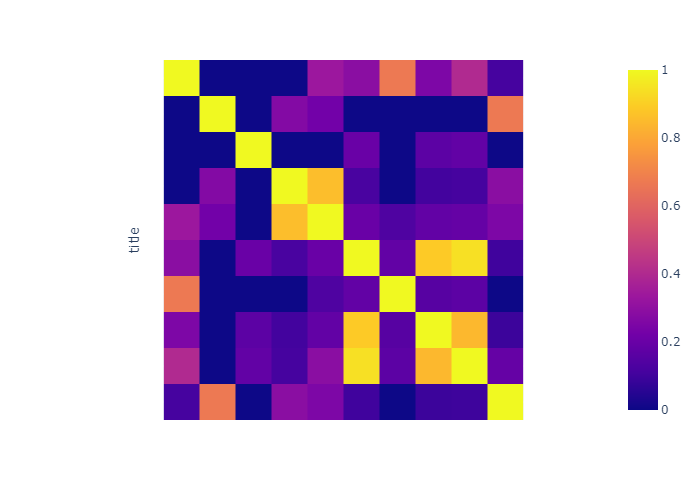

In [35]:
# Test different similarities
thresholds = list(range(1,10))
independences = []
for i in thresholds:
    print('Similarity: {}%'.format(i * 10))
    titles_stripped, features, fig, mean_independence = full(titles, 0.1 * i, 1)
    print(features)
    print('Mean independence: {}'.format(round(mean_independence,2)))
    independences.append(round(mean_independence,2))
    print()
fig.show("png")
#fig.write_html("path/to/file.html")

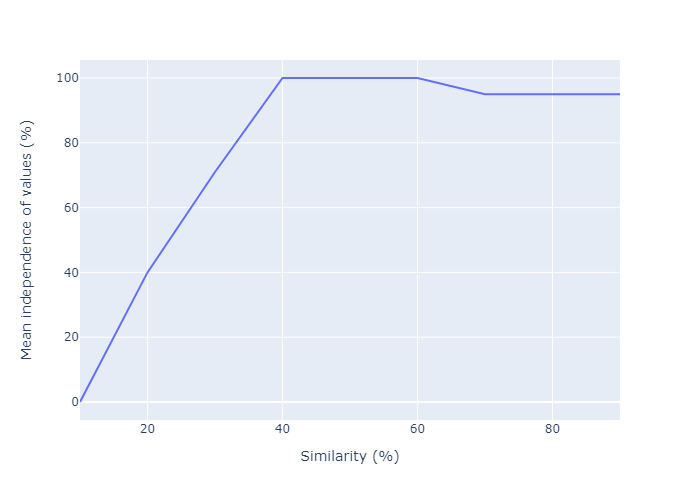

In [23]:
# Review feature independence for different similarity thresholds to determine optimal threshold parameter to use 
# Could also review complexity of elements
thresholds_percent = [i * 10 for i in thresholds]
independences_percent = [i * 100 for i in independences]
fig = px.line(
    x=thresholds_percent,
    y=independences_percent,
    labels=dict(x="Similarity (%)", y="Mean independence of values (%)"))
fig.show("png")


['virgin', 'bt', 'vodaphone', 'talk', 'sky']
[10, 5]


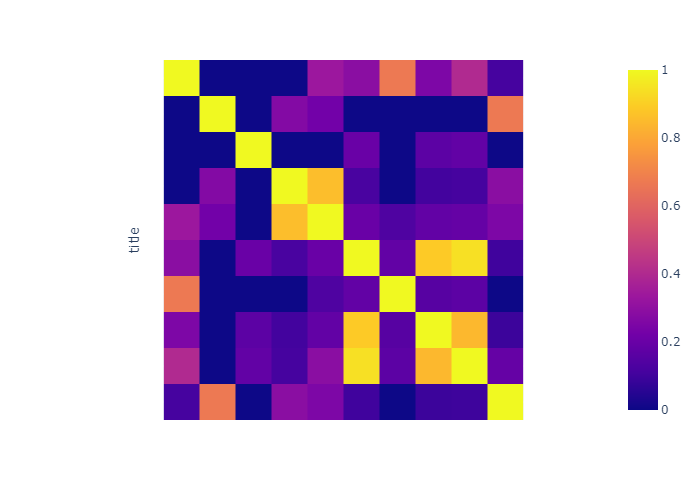

In [24]:
# 40% and 50% similarity gave the same features I'd wish to group by in this case
titles_stripped, features, fig, mean_independence = full(titles, 0.5, 1)
print(features)
fig.show("png")

In [31]:
# Substitute the stripped down titles into the DataFrame.
list_1 = []
for i in df_broadband['broadband']:
    list_2 = []
    for j in titles_stripped:
        if j in i.lower():
            list_2.append(j)
        else:
            pass
    if list_2:
        list_1.append(list_2[0])
    else:
        list_1.append(i)
df_broadband['broadband_stripped'] = list_1
df_broadband.head(10)

,broadband,ratings,years,month_cost,broadband_stripped
0,BT,2,5,32,bt
1,Sky,2,2,33,sky
2,Sky UK,1,5,21,sky
3,Sky uk ltd,3,6,32,sky
4,Sky uk limited,1,5,32,sky
5,Virgin,5,1,21,virgin
6,Virgin Media,5,7,35,virgin
7,Vodaphone,2,3,26,vodaphone
8,vodaphone uk,5,4,24,vodaphone
9,talk talk,1,7,22,talk


In [32]:
# Aggregate the DataFrame for data analysis
df_means = df_broadband.groupby('broadband_stripped').mean()
df_means.reset_index(inplace=True)

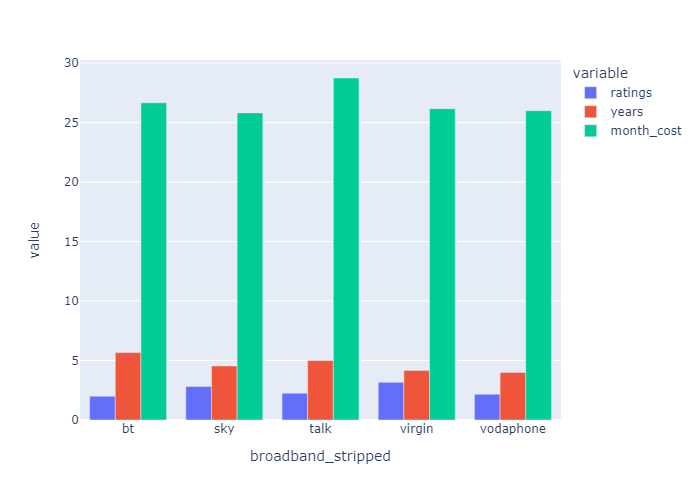

In [33]:
# Averages plots per provider
fig = px.bar(df_means,x='broadband_stripped',y=['ratings','years','month_cost'], barmode='group')
fig.show("png")

In [ ]:
# Scalability of solution we are doing x^2 comparisons
# order of magnitude when comparing 10 vs 100 vs 1000, becomes a bit unruly.
# demo of this (run times, note visualisations become impossible at this point)
# can use partitions of the sample to stop at stable state
# collect these results and then iterate through
# can run in parallel (RDD if happen to be using Spark, or concurrent.futures, or similar python concurrency tools)

# git notes:
# fig.show() vs fig.show("png") will allow for responsive plotly graphs
